In [1]:
import sys  
import os
sys.path.insert(0, os.path.join(os.path.abspath(os.getcwd()), ".."))

import json
import glob
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
from utils import *

In [2]:
CATEGORY_MAP = {
    "good_chili": 1,
    "bad_chili": 2
}

PROJECT_NAME = "goodbadchili"
DESIRED_HEIGHT, DESIRED_WIDTH = 288, 512  # 288, 512
FOLDER_NAME = "train"

In [3]:
PROJECT_DATASET_DIR = os.path.join(os.path.abspath(os.getcwd()), "..", "..", "datasets", PROJECT_NAME)
PASCALVOC_IMAGE_DIR = os.path.join(PROJECT_DATASET_DIR, "PASCALVOC", FOLDER_NAME)

img_paths = glob.glob(os.path.join(PASCALVOC_IMAGE_DIR, "*.JPG"))
img_paths += glob.glob(os.path.join(PASCALVOC_IMAGE_DIR, "*.jpg"))

In [4]:
def get_bbox(root, annotation_id, image_id, scale=1, padded_height=0):
    res = []
    for object in root.findall('object'):
        lst = (float(object.find("bndbox").find(pos).text) for pos in ["xmin", "ymin", "xmax", "ymax"])
        [xmin, ymin, xmax, ymax] = [n//scale for n in lst]
        ymin, ymax = ymin + padded_height, ymax + padded_height
        quality = object.find("name").text
        res.append(Annotation(annotation_id, image_id, CATEGORY_MAP[quality], xmin, ymin, xmax, ymax).to_dict())
        annotation_id += 1
    return res, annotation_id

In [5]:
d = init_dict()
annotation_id = 0
fails, alt = [], []
fail_flag = False
for i, path in tqdm(enumerate(img_paths)):
    try:
        root = ET.parse(path.replace(".jpg", ".xml").replace(".JPG", ".xml")).getroot()
        size = root.find('size')
        image_height, image_width = int(size.find('height').text), int(size.find('width').text)
        image, padded_height = pad_image(
            cv2.resize(
                cv2.imread(path),
                (DESIRED_WIDTH, DESIRED_HEIGHT),
                interpolation=cv2.INTER_AREA
            ), DESIRED_HEIGHT, DESIRED_WIDTH
        )
        image_meta = Image(i, f"{i}.jpg").to_dict()
        annotations, annotation_id = get_bbox(root, annotation_id, i, scale=image_width/DESIRED_WIDTH, padded_height=padded_height)
        d["images"].append(image_meta)
        d["annotations"].extend(annotations)
        cv2.imwrite(os.path.join(PROJECT_DATASET_DIR, "COCO", FOLDER_NAME, f"{i}.jpg"), image)
    except Exception as e:
        if not fail_flag:
            print("[Error]", e)
            fail_flag = True
        fails.append((path, e))

with open(os.path.join(PROJECT_DATASET_DIR, "COCO", "annotations", f"instances_{FOLDER_NAME}.json"), "w") as f:
    json.dump(d, f, indent=4)

2924it [00:30, 96.49it/s] 


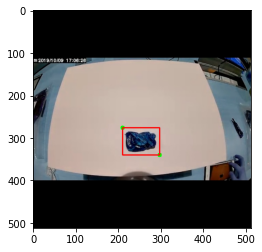

In [6]:
image_id = 336
img = cv2.imread(os.path.join(PROJECT_DATASET_DIR, "COCO", FOLDER_NAME, f"{image_id}.jpg"))
bbox = [x['bbox'] for x in d['annotations'] if x["image_id"] == image_id]
for bb in bbox:
    plot_bbox(img, bb)